In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools
import pickle

from os.path import join
from os import listdir
from glob import glob
from cv2 import imread

from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

from ipywidgets import interact, fixed

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from importlib import reload # for reloading utils after code changes

%matplotlib inline

In [2]:
# reloading all code for easier code development
import utils; reload(utils)
from utils import *

import utils2; reload(utils2)
from utils2 import *

# 1. Data Preparation

All code in the cell below was used to read in all images, make sure they are in range `(0,255)` and then pickle them in folder.

I used the following code to prepare the data and pickle it to folder:
```python
veh = 'data/vehicles/'
nonveh = 'data/non-vehicles/'
pickle_veh_path = 'data/vehicles.p'
pickle_nonveh_path = 'data/non-vehicles.p'

veh_data = make_data(veh, pickle_veh_path)
print("Shape of vehicles data:", veh_data.shape)

nonveh_data = make_data(nonveh, pickle_nonveh_path)
print("Shape of nonvehicles data:", nonveh_data.shape)

veh_labels = np.ones(len(veh_data)).astype(np.uint8)
nonveh_labels = np.zeros(len(nonveh_data)).astype(np.uint8)

labels = np.hstack([veh_labels, nonveh_labels])
print("Number of labels:", labels.shape)

data = np.vstack([veh_data, nonveh_data])
print("Shape of all data:", data.shape)

data.dump('data/data.p')
labels.dump('data/labels.p')
```
Now, I don't need to run this every time. I can just load data directly into memory.
Note that data is in the same order as in folders, so I will need to shuffle it for training and testing.

# 2. Data Exploration and Visualization

In [3]:
# for persisting data
path_data = 'data/data.p'
path_labels = 'data/labels.p'
path_clf = 'data/clf.p'
path_scaler = 'data/scaler.p'

# paths for videos
test_video_path = 'test_video.mp4'
full_video_path = 'project_video.mp4'

X = np.load(path_data)
y = np.load(path_labels)

In [4]:
summarize(X, 'images')
summarize(y, 'labels')

Shape of images data: (17760, 64, 64, 3)
dtype of images data: uint8
Range of images data: (0,255)

Shape of labels data: (17760,)
dtype of labels data: uint8
Range of labels data: (0,1)



The `n_cars` below is used for plotting cars vs. non-cars.

Pickled data is ordered, first `n_cars` rows are cars, remaining rows are non-cars.

I will use this to index cars vs. non-cars when plotting random images to get a better feel of the data.

In [5]:
n_cars = len(y[y == 1])
n_noncars = len(y[y != 1])
print("There are {} cars in the data set.".format(n_cars))
print("There are {} non-cars in the data set.".format(n_noncars))

There are 8792 cars in the data set.
There are 8968 non-cars in the data set.


Let us examine visually some random images from either class. Not that the images are in RGB, ranged from 0 to 255.

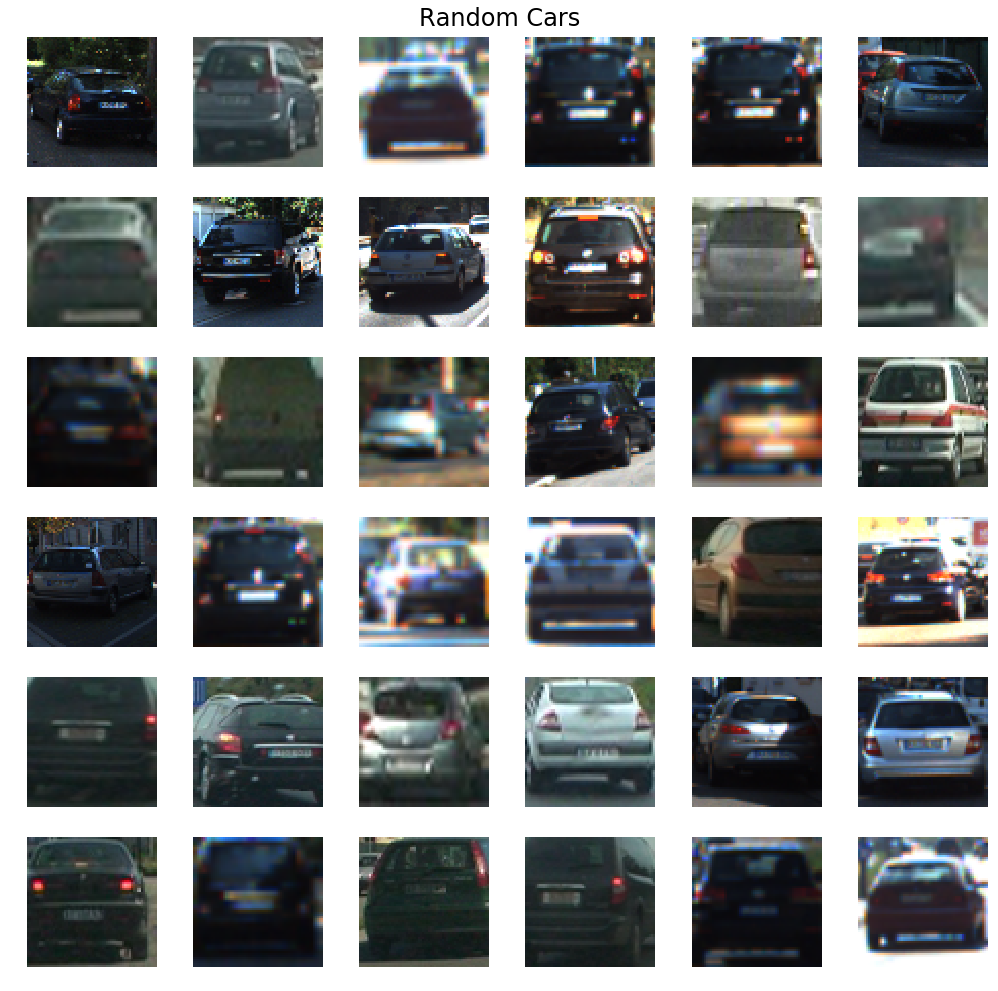

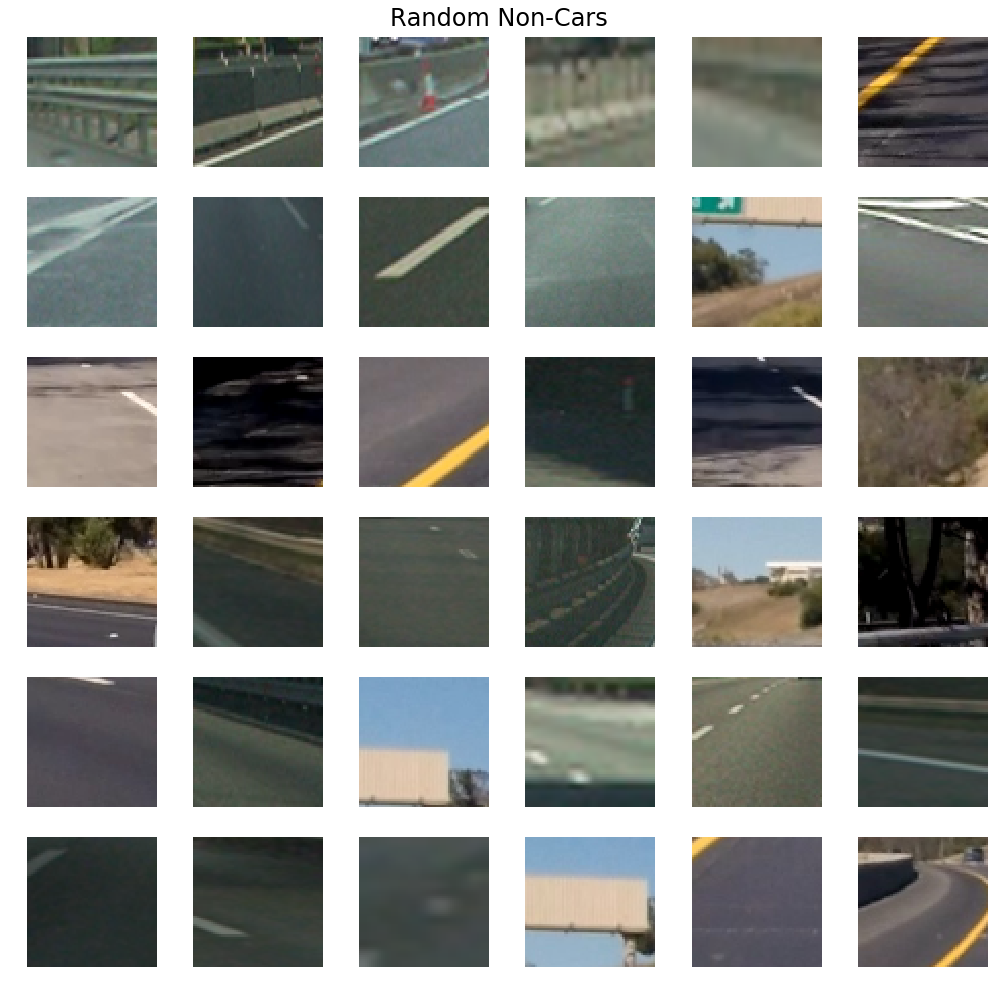

In [6]:
np.random.seed(42)

# plot random cars
car_imgs, car_labels, _ = plot_random_data(X[:n_cars], figsize=(14,14), title='Random Cars', savepath='figures/random-cars.jpg')

# plot random non-cars
noncar_imgs, noncar_labels, _ = plot_random_data(X[n_cars:], figsize=(14,14), title='Random Non-Cars', savepath='figures/random-noncars.jpg')

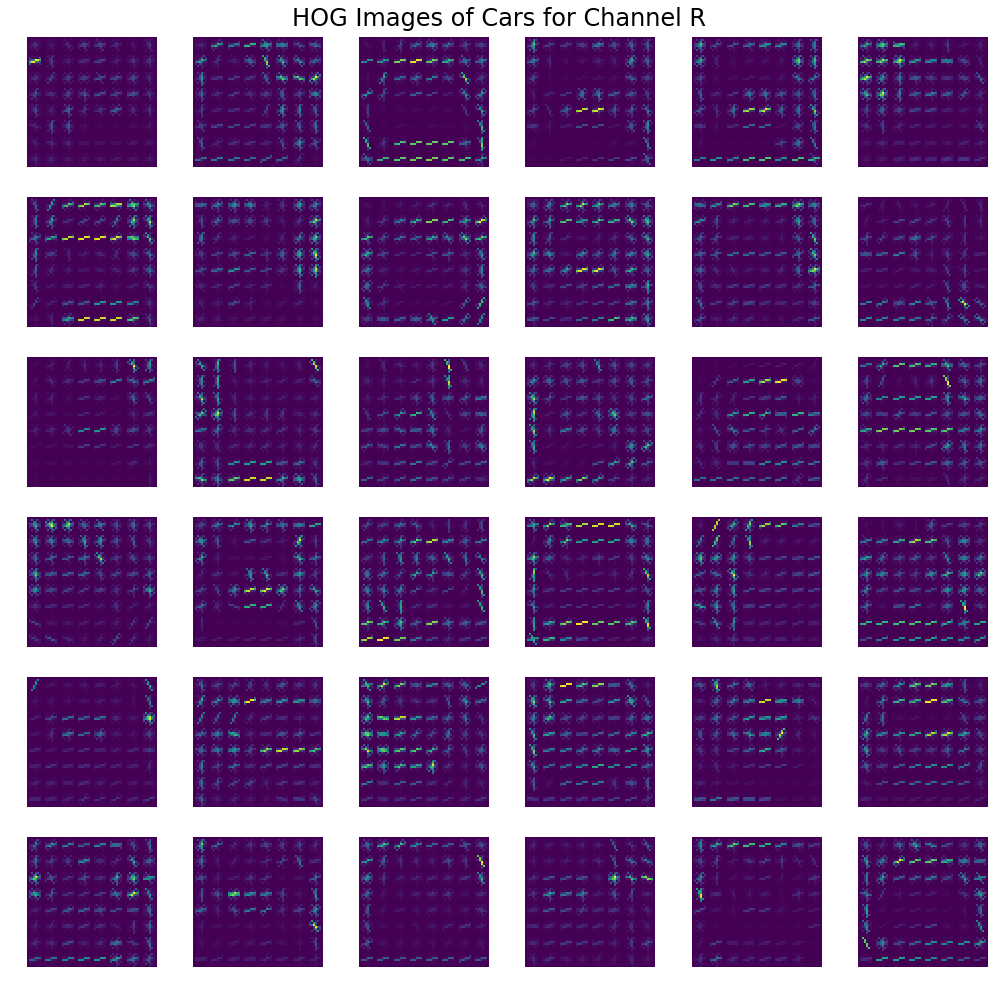

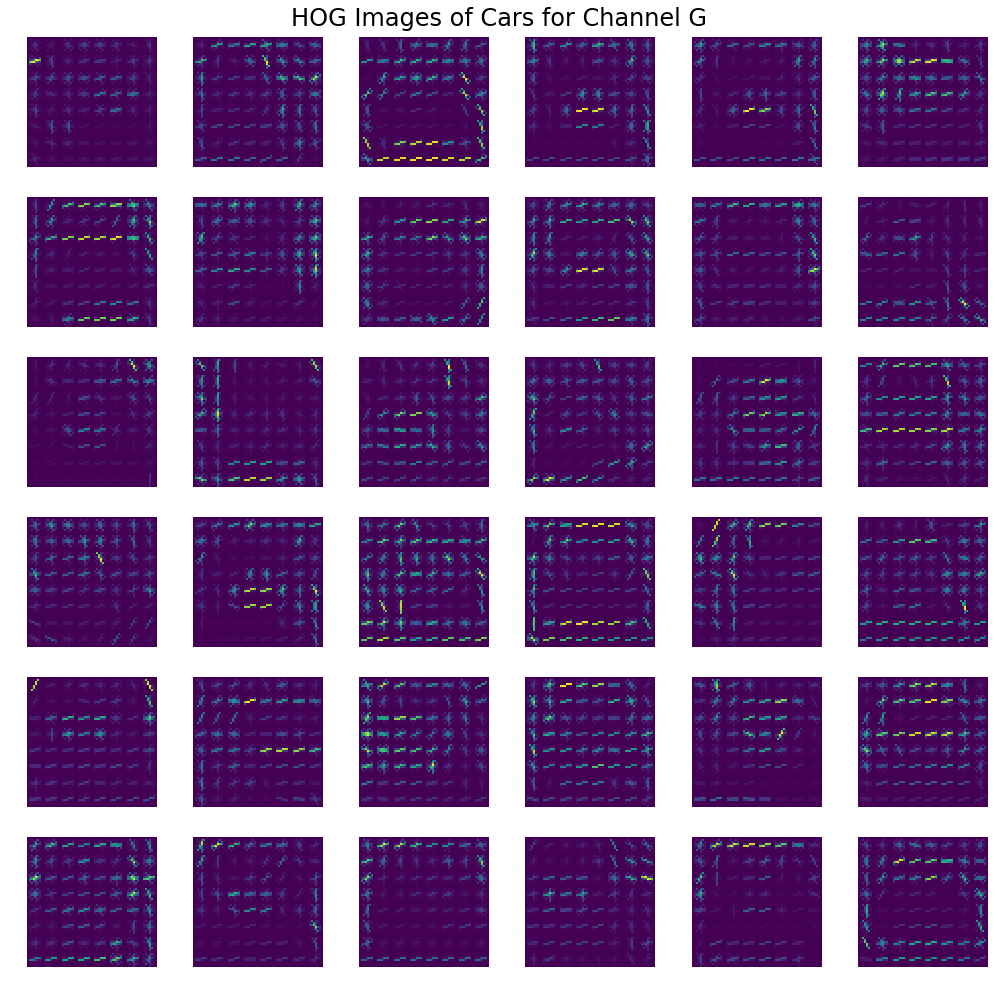

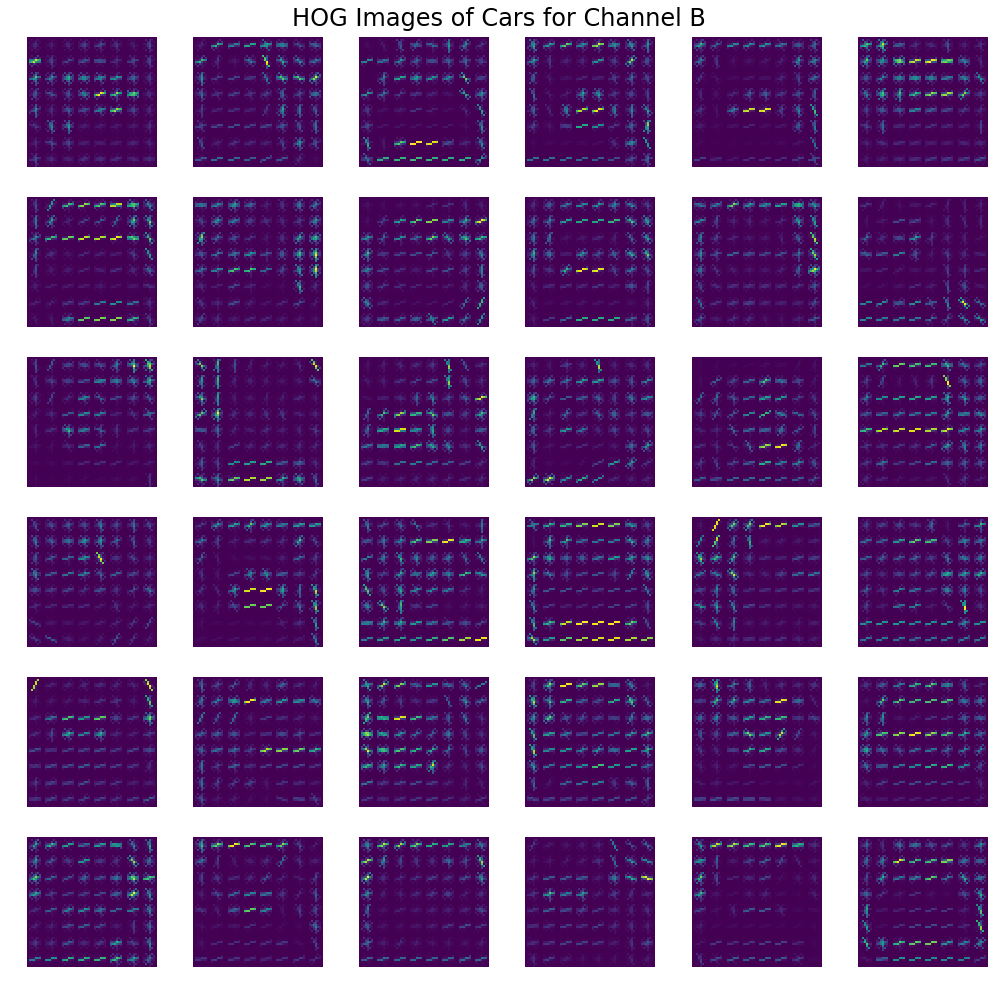

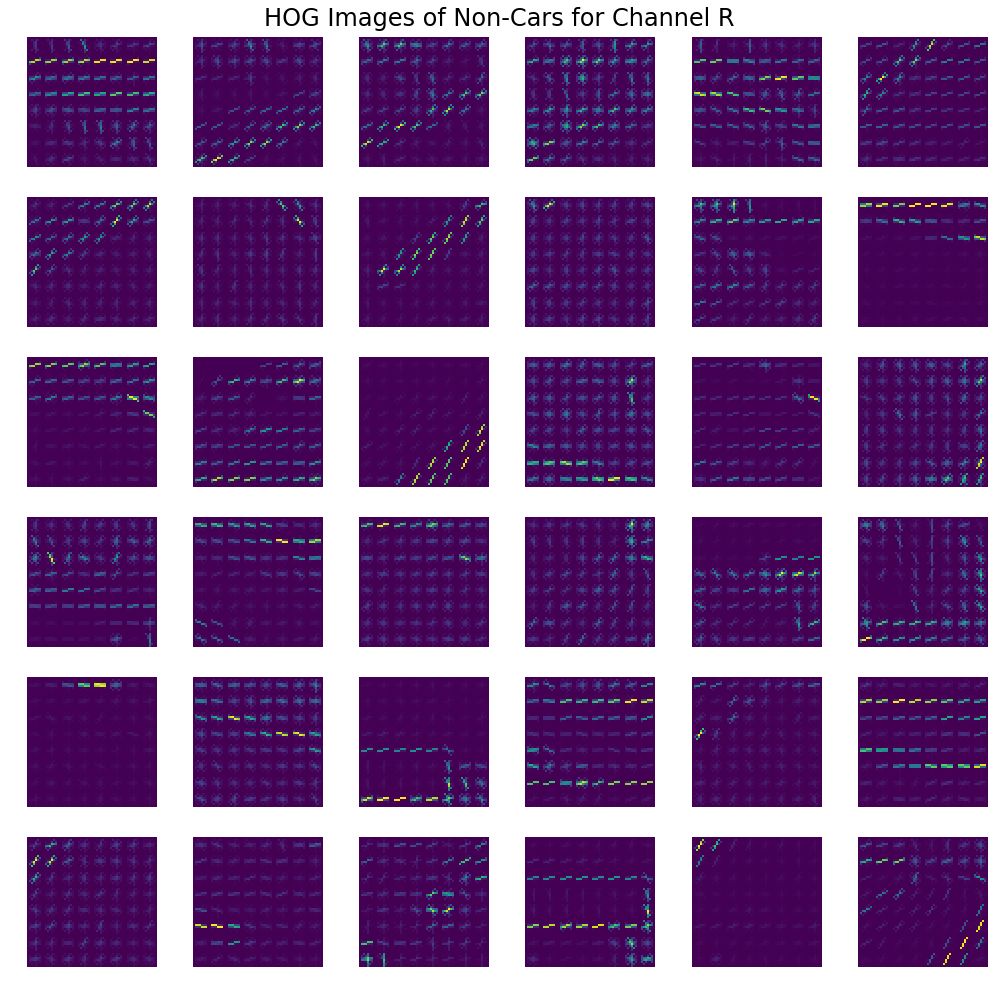

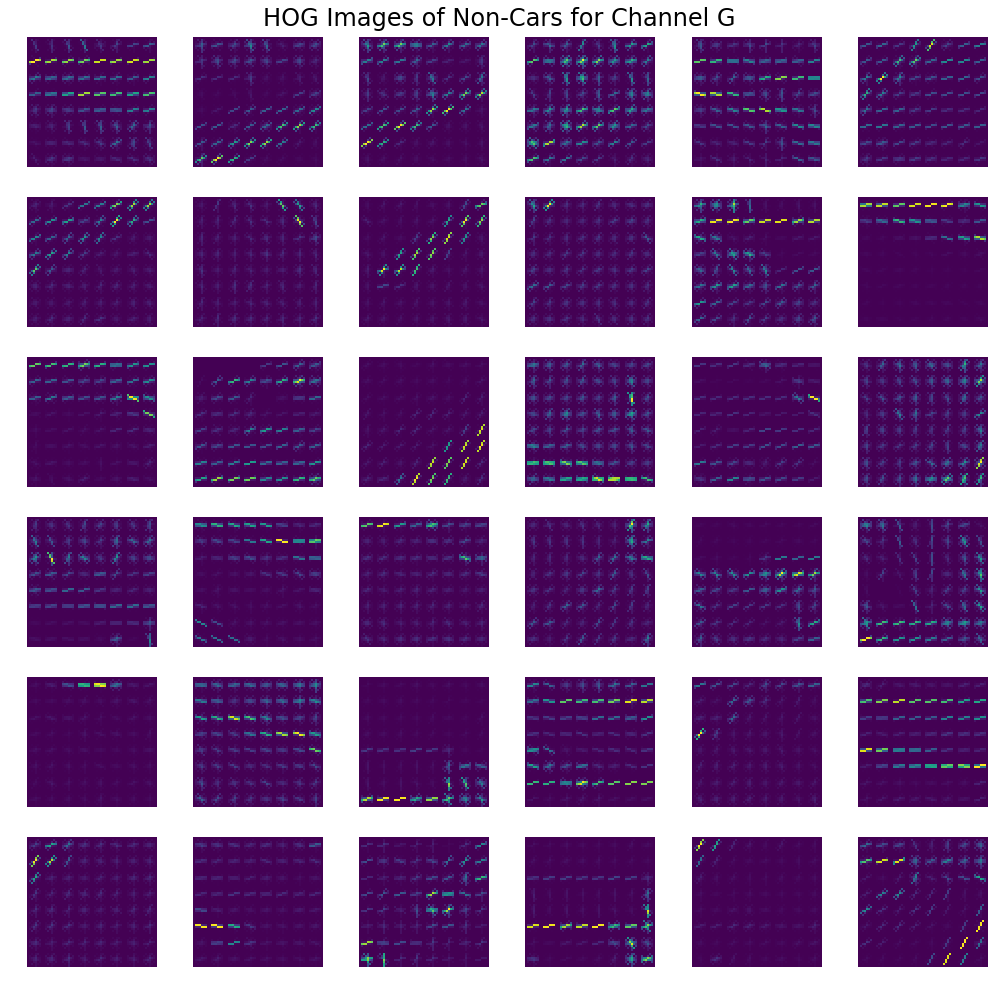

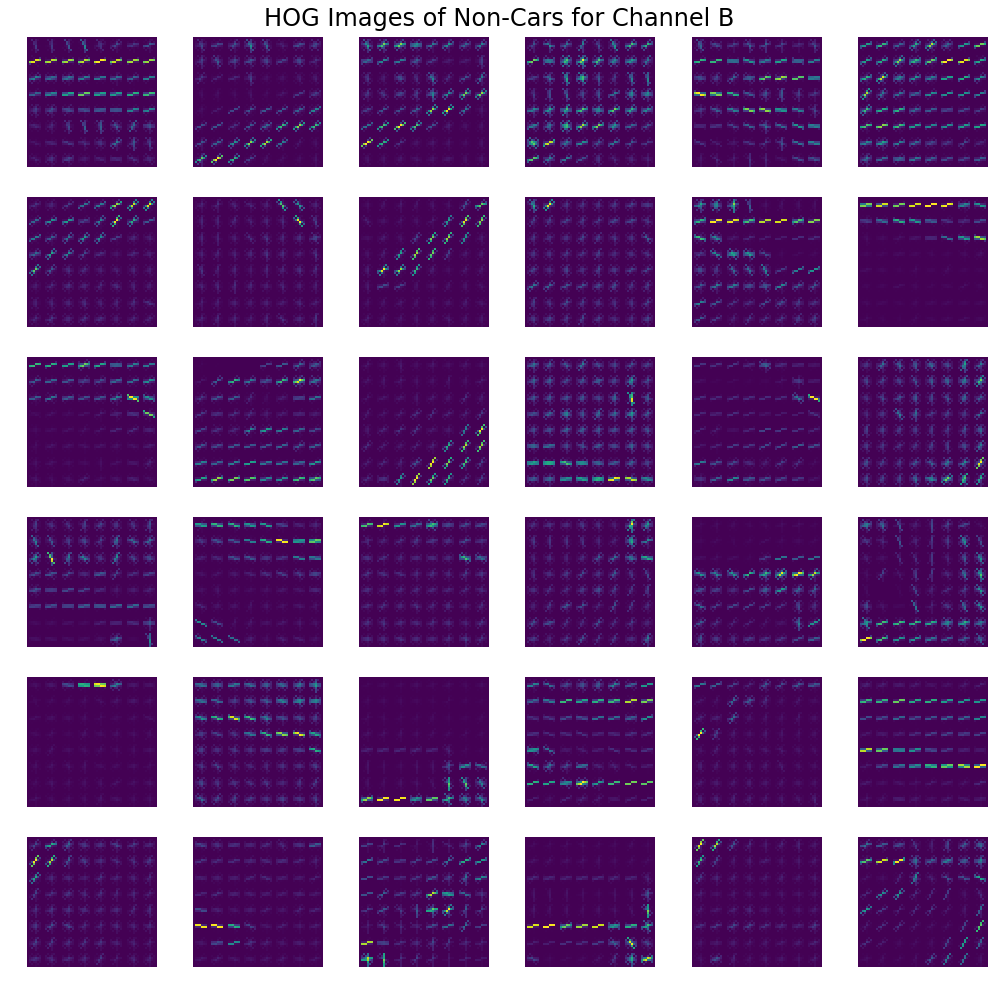

In [7]:
for c in range(3):
    save_to = 'figures/hog-images-cars-channel-{}.jpg'.format(['R','G','B'][c])
    plot_hog_imgs(car_imgs, car_labels, "Cars", c, save_to)
    
for c in range(3):
    save_to = 'figures/hog-images-noncars-channel-{}.jpg'.format(['R','G','B'][c])
    plot_hog_imgs(noncar_imgs, noncar_labels, "Non-Cars", c, save_to)

<function utils2.plotChannels>

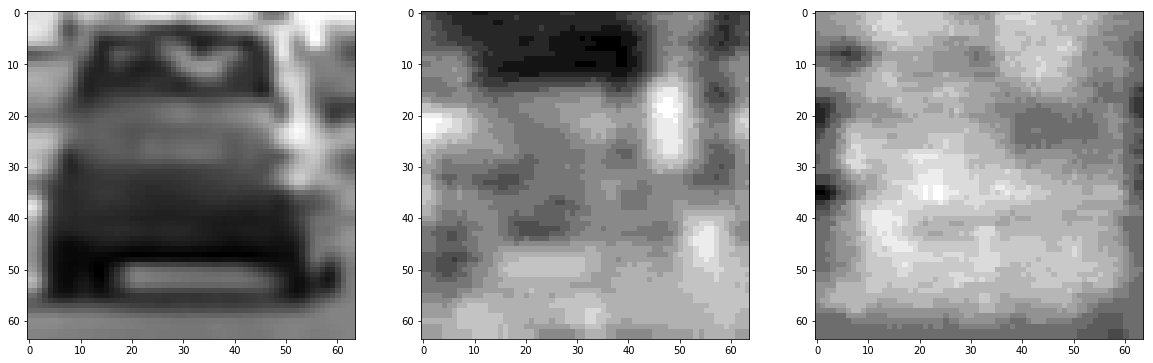

In [8]:
# select some image for plotting the channels
img = X[56]

# interactively plot channels for different color spaces
interact(plotChannels, 
         image=fixed(img),
         cspace={'RGB':'RGB', 'HSV':'HSV', 'LUV':'LUV', 'HLS':'HLS', 'YUV':'YUV', 'YCrCb':'YCrCb'})

# 3. Extracting Features and Training a Classifier

Let us extract some features and then train a classifier.

Code in cell below is taken from Udacity classroom examples.

I changed code so that it accepts data from memory that I prepared above and does not read images from disk.

In [9]:
%time features = extract_features(X, orient=9, pix_per_cell=8, cell_per_block=2, cspace='YUV', hog_channel='ALL')

CPU times: user 44.9 s, sys: 440 ms, total: 45.4 s
Wall time: 45.5 s


In [10]:
summarize(features, 'HOG, hist, spacial features', stats=True)

Shape of HOG, hist, spacial features data: (17760, 4932)
dtype of HOG, hist, spacial features data: float32
Range of HOG, hist, spacial features data: (0.0,4096.0)
Mean value of HOG, hist, spacial features: 72.17865753173828
SD of HOG, hist, spacial features: 85.01239013671875



We can see that the range of data is quite high, in addition it is not centered at zero and SD is not 1, as per project's requirements. We will need to normalize it.

In [11]:
normalizer = StandardScaler()
normalizer.fit(features)
features_normalized = normalizer.transform(features)

Let us examine normalized features.

In [12]:
summarize(features_normalized, 'HOG, hist, spacial features normalized', stats=True)

Shape of HOG, hist, spacial features normalized data: (17760, 4932)
dtype of HOG, hist, spacial features normalized data: float32
Range of HOG, hist, spacial features normalized data: (-14.671391487121582,126.76688385009766)
Mean value of HOG, hist, spacial features normalized: 9.17802580602256e-08
SD of HOG, hist, spacial features normalized: 0.9991886019706726



Now, it is time to prepare train and test data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features_normalized, y, test_size=0.2)

In [14]:
summarize(X_train, "train data", stats=True)
summarize(X_test, "test data", stats=True)
summarize(y_train, "train labels", stats=True)
summarize(y_test, "test labels", stats=True)

Shape of train data data: (14208, 4932)
dtype of train data data: float32
Range of train data data: (-13.785971641540527,126.76688385009766)
Mean value of train data: 0.0005348142003640532
SD of train data: 0.9963635802268982

Shape of test data data: (3552, 4932)
dtype of test data data: float32
Range of test data data: (-14.671391487121582,121.36952209472656)
Mean value of test data: -0.0021393457427620888
SD of test data: 1.0104120969772339

Shape of train labels data: (14208,)
dtype of train labels data: uint8
Range of train labels data: (0,1)
Mean value of train labels: 0.49570664414414417
SD of train labels: 0.49998156675571037

Shape of test labels data: (3552,)
dtype of test labels data: uint8
Range of test labels data: (0,1)
Mean value of test labels: 0.49239864864864863
SD of test labels: 0.49994221611865636



Nice. It is time to train a classifier. I am using `LinearSVC` based on readings online. But I do not know the best value of regularization parameter `C`. So I am going to use `GridSearchCV` for that purpose.

In [15]:
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc = LinearSVC()
# clf = LinearSVC(C=10)

clf = GridSearchCV(svc, params)

%time clf.fit(X_train, y_train)

CPU times: user 4min 41s, sys: 21.6 s, total: 5min 3s
Wall time: 5min 20s


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

What is the best parameter value?

In [16]:
clf.best_params_

{'C': 0.001}

Is the accuracy good enough?

In [17]:
y_preds = clf.predict(X_test)
acc = accuracy_score(y_test, y_preds)
print("Accuracy on the test set is {:.4f}".format(acc))

Accuracy on the test set is 0.9845


Accuracy is good, but what about false positive and false negative rates?

Let's examine confusion matrix of this classifier.

Confusion matrix, without normalization


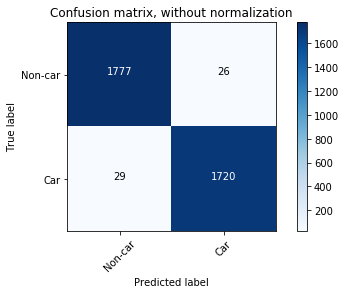

Normalized confusion matrix


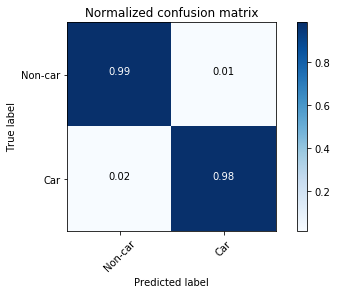

In [18]:
class_names = ['Non-car', 'Car']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('figures/confusion.jpg', bbox_inches='tight')
plt.show()


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('figures/confusion-norm.jpg', bbox_inches='tight')
plt.show()


Saving and loading classifier and scaler for easy later use.

In [19]:
pickle.dump( clf, open( path_clf, "wb" ) )
pickle.dump( normalizer, open( path_scaler, "wb" ) )

In [20]:
loaded_clf = pickle.load( open( path_clf, "rb" ) )
loaded_normalizer = pickle.load( open( path_scaler, "rb" ) )

# 4. Recognising Cars in Images

Before moving to the video car-recognition pipeline, I am going to make it work on single images first.

Of course, there will be some false positives, which I cannot deal with using a single frame, but this problem will be addressed in the next section.

I have dumped some frames from the video. Let's use some of those frames and try to detect vehicles by using the classifier that I trained and sliding windows approach.

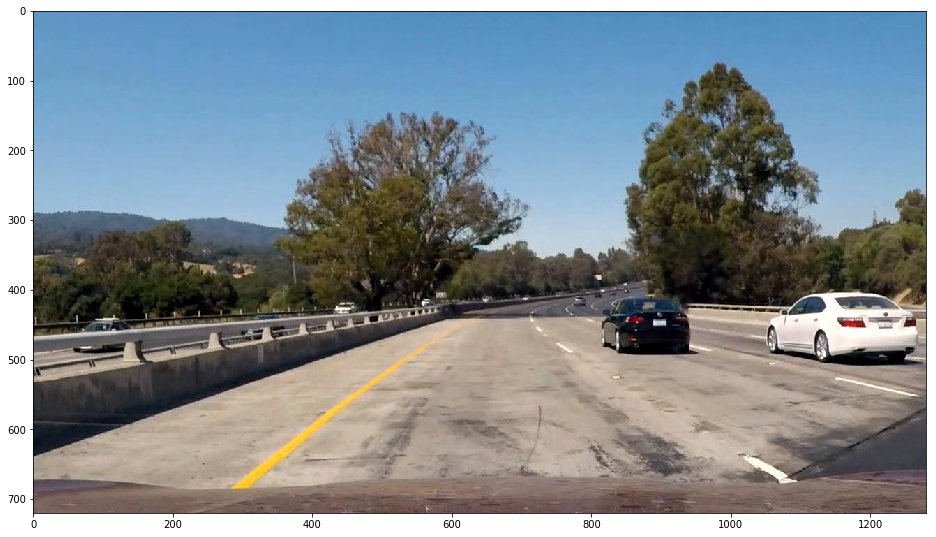

In [21]:
test_path = 'dump'
test_imgs = glob(join(test_path, '*.jpg'))
img = imread(test_imgs[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plot(img)

Let's first define region of interest: we only interested in the region in front of the car befor the horizon.

We dont' really want to detect any cars in the trees or in the sky, even if there are, which would be weird but outside the scope of our detection system.

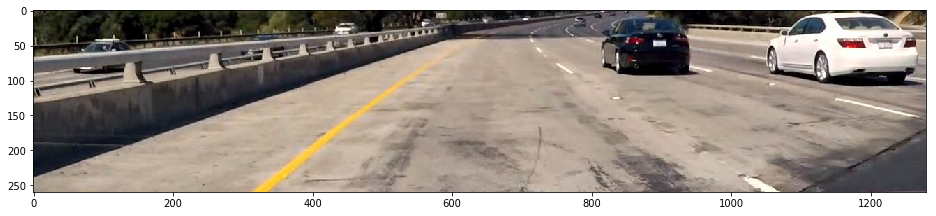

In [22]:
plot(crop(img))

Now that we have a region that we are interested in, let's try to draw some boxes and also apply sliding window and see how it works.

In [23]:
test_y_vals = range(450, 511, 10)
boxes = []
for i in test_y_vals:
    bsize = box_size(i, horizon=450, min_box=64, max_box = 192, y_max=500)
    y_start = np.round(i - bsize/2).astype(np.int)
    y_end = np.round(y_start + bsize).astype(np.int)
    x_start = np.round(200 + (i + bsize/2)*1.2).astype(np.int)
    x_end = np.round(x_start + bsize).astype(np.int)
    coords = ((x_start, y_start),(x_end, y_end))
    boxes.append(coords)
    
boxes[-1]

((942, 402), (1159, 619))

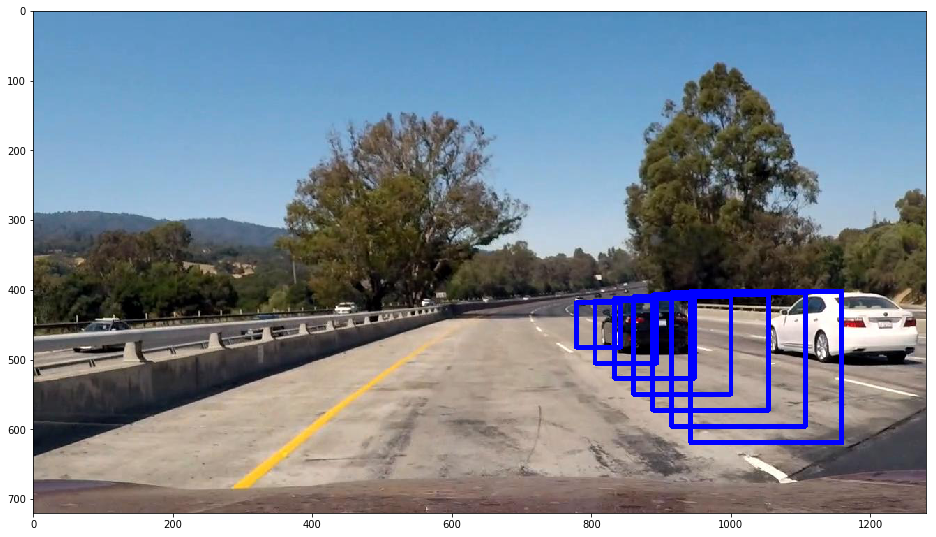

In [24]:
box_img = draw_boxes(img, boxes)

# plot(box_img, savepath='figures/dynamic-boxes.jpg')
plot(box_img)

Modified slide window function that takes into account dynamically allocated scanning windows sizes.

In [25]:
wlist = slide_dynamic_window(img, y_limit=(440, 511), horizon=450, 
                             min_box=64, max_box=160, 
                             y_max=500, x_overlap=0.5, n_vert_windows=20)
len(wlist)

484

In [26]:
rand_idx = np.random.randint(len(wlist), size=100)
rand_wlist = []
for idx in rand_idx:
    box = wlist[idx]
    rand_wlist.append(box)

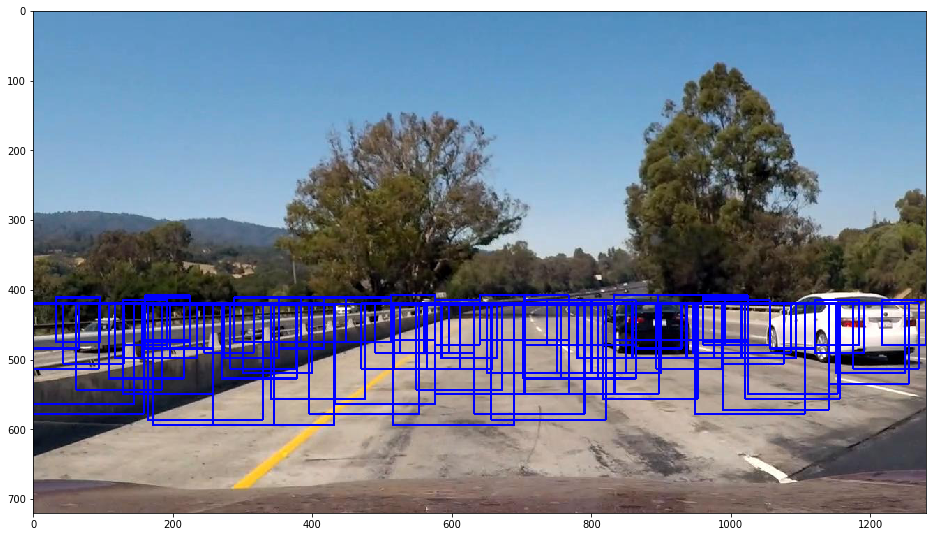

In [27]:
test_box_img = draw_boxes(img, rand_wlist, thick=2)

# plot(test_box_img, savepath='figures/dynamic-boxes-random.jpg')
plot(test_box_img)

Now that we can generate boxes that will look for cars, let's put it all together.

Code below is from Udacity classroom, modified to work properly with dynamically sized search windows.

In [28]:
%time test_cars_boxes = search_windows(img, wlist, loaded_clf, loaded_normalizer)

CPU times: user 1.37 s, sys: 10.9 ms, total: 1.39 s
Wall time: 1.41 s


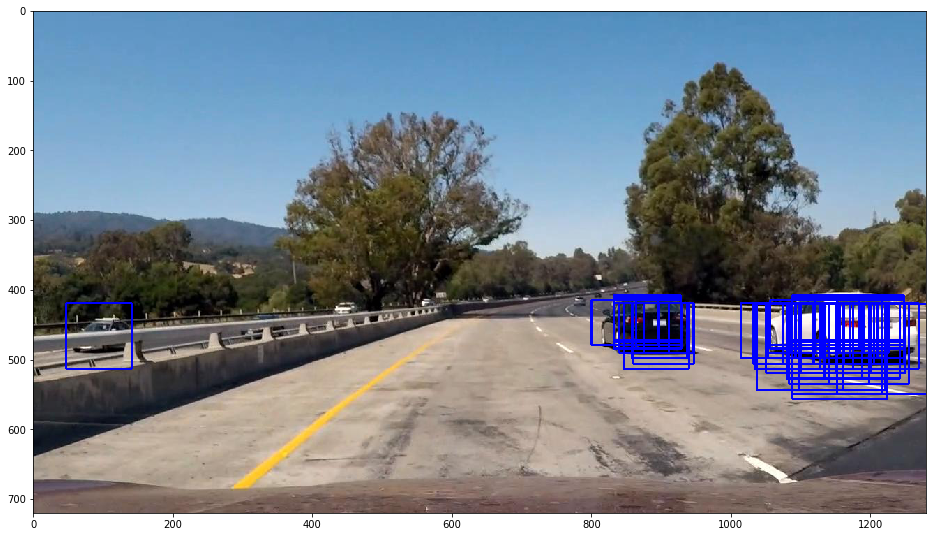

In [29]:
test_cars_img = draw_boxes(img, test_cars_boxes, thick=2)

plot(test_cars_img, savepath='figures/test-cars.jpg')

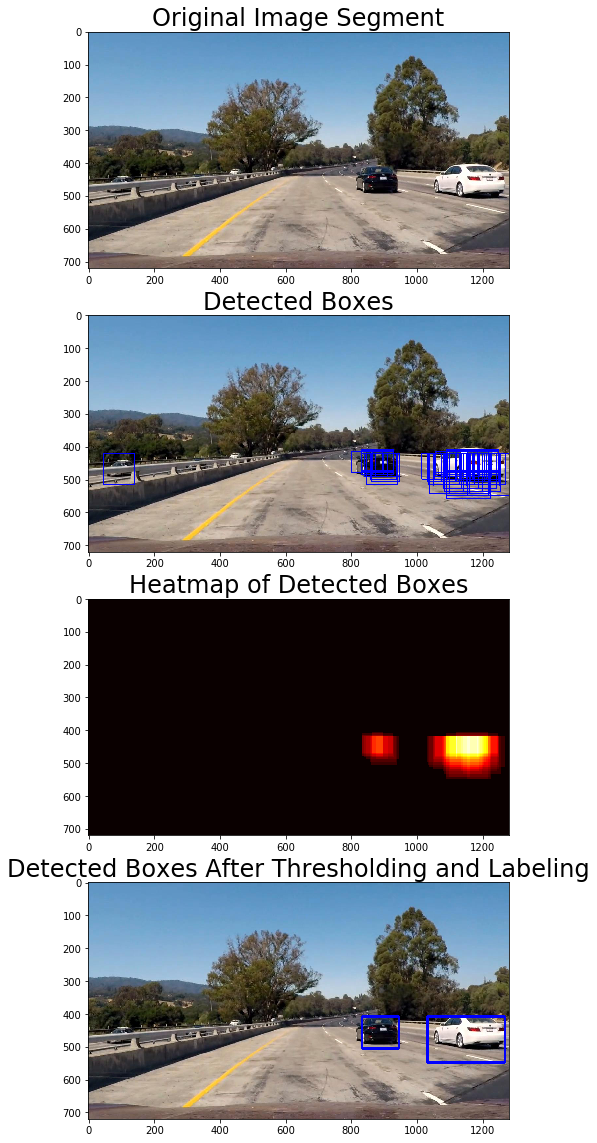

In [39]:
# plot all the steps of single-image pipeline
_, _ = labeled_image(img, test_cars_boxes, 1, True)

---

# 5. Simple Pipeline for Videos

---
Simple pipeline that takes into account only current frame information. I expect to see some false positives, but I will deal with them later.

In [41]:
def process_image_simple(img):
    thresh = 3
    
    # returns all sliding windows
    wlist = slide_dynamic_window(img, 
                                 y_limit=(440, 511), horizon=450, 
                                 min_box=64, max_box=160, y_max=500, 
                                 x_overlap=0.5, n_vert_windows=20)
    
    # detected cars
    cars_boxes = search_windows(img, wlist, loaded_clf, loaded_normalizer)
    
    # 
    _, _ = labeled_image(img, cars_boxes, thresh, inplace=True)
    
    return img

In [42]:
simple_test_video_out = 'output_videos/simple_test_video_out.mp4'
clip_test = VideoFileClip(test_video_path)
clip_test_out = clip_test.fl_image(process_image_simple)
%time clip_test_out.write_videofile(simple_test_video_out, audio=False)

[MoviePy] >>>> Building video output_videos/simple_test_video_out.mp4
[MoviePy] Writing video output_videos/simple_test_video_out.mp4


 97%|█████████▋| 38/39 [00:53<00:01,  1.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/simple_test_video_out.mp4 

CPU times: user 52.3 s, sys: 452 ms, total: 52.7 s
Wall time: 54.6 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(simple_test_video_out))

In [44]:
simple_full_video_out = 'output_videos/simple_full_video_out.mp4'
clip_test = VideoFileClip(full_video_path)
clip_test_out = clip_test.fl_image(process_image_simple)
%time clip_test_out.write_videofile(simple_full_video_out, audio=False)

[MoviePy] >>>> Building video output_videos/simple_full_video_out.mp4
[MoviePy] Writing video output_videos/simple_full_video_out.mp4


100%|█████████▉| 1260/1261 [29:55<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/simple_full_video_out.mp4 

CPU times: user 29min 4s, sys: 17.2 s, total: 29min 22s
Wall time: 29min 57s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(simple_full_video_out))

The output video still shows some false positives, even though there is thresholding applied.

I am going to use multiple frames to calculate heatmaps and threshold.

# 6. Advanced Pipeline for Videos

In [46]:
# Define a class to store data from video
# NOTE: this simple class is inspired by:
#    https://github.com/jeremy-shannon/CarND-Vehicle-Detection/
class Frame_Stats():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_boxes = [] 
        
    def add_boxes(self, rects):
        self.prev_boxes.append(rects)
        if len(self.prev_boxes) > 15:
            # throw out oldest rectangle set(s)
            self.prev_boxes = self.prev_boxes[len(self.prev_boxes)-15:]

            
def process_image_advanced(img):
    
    # returns all sliding windows
    wlist = slide_dynamic_window(img, 
                                 y_limit=(440, 511), horizon=450, 
                                 min_box=64, max_box=160, y_max=500, 
                                 x_overlap=0.5, n_vert_windows=10)
    
    # detected cars
    detected_boxes = search_windows(img, wlist, loaded_clf, loaded_normalizer)

    # apply to list of previous frames detected boxes
    if len(detected_boxes) > 0:
        stat.add_boxes(detected_boxes)


    # heat maps over last frames
    heat = np.zeros_like(img[:,:,0])
    for rect_set in stat.prev_boxes:
        heat = add_heat(heat, rect_set)

    # threshold value
    thresh = 25
  
    # apply threshold to accumulated heatmap
    heat = apply_threshold(heat, thresh)

    labels = label(heat)
    labeled_img, labels_boxes = draw_labeled_bboxes(img, labels, inplace=True)
    
    return img

In [47]:
stat = Frame_Stats()

advance_test_video_out = 'output_videos/advance_test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image_advanced)
%time clip_test_out.write_videofile(advance_test_video_out, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(advance_test_video_out))

[MoviePy] >>>> Building video output_videos/advance_test_video_out.mp4
[MoviePy] Writing video output_videos/advance_test_video_out.mp4


 97%|█████████▋| 38/39 [00:27<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/advance_test_video_out.mp4 

CPU times: user 26.3 s, sys: 297 ms, total: 26.6 s
Wall time: 28.3 s


In [48]:
stat = Frame_Stats()

advanced_full_video_out = 'output_videos/advanced_full_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image_advanced)
%time clip_test_out.write_videofile(advanced_full_video_out, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(advanced_full_video_out))

[MoviePy] >>>> Building video output_videos/advanced_full_video_out.mp4
[MoviePy] Writing video output_videos/advanced_full_video_out.mp4


100%|█████████▉| 1260/1261 [15:09<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/advanced_full_video_out.mp4 

CPU times: user 14min 49s, sys: 8.73 s, total: 14min 58s
Wall time: 15min 10s


---